## RQ1 — Testing Behavior Analysis

## 0. Notebook Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)


## 1. Load AIDev Dataset

In [2]:
all_pr = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
pr_commit_details = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commit_details.parquet")
pr_task_type          = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")

## 2. Identify Test Files in PR Commits

In [3]:
all_pr = all_pr
commit = pr_commit_details
task_type = pr_task_type


In [4]:
TEST_PATTERN = r"(?i)(?:^|/)(?:tests?/|test_|_test|__tests__/)"

commit["is_test_file"] = commit["filename"].str.contains(TEST_PATTERN, regex=True, na=False).astype(bool)
commit["test_file_count"] = commit["is_test_file"].astype(int)

## 3. Aggregate to PR Level

In [5]:
pr_test_agg = (
    commit.groupby("pr_id")
    .agg(
        contains_test=("is_test_file", "any"),
        test_file_count=("test_file_count", "sum"),
    )
    .reset_index()
)


## 4. Merge PR Metadata

In [6]:
pr_merged = all_pr.merge(
    pr_test_agg,
    left_on="id",
    right_on="pr_id",
    how="left"
)

pr_merged["contains_test"] = pr_merged["contains_test"].fillna(False).astype(bool)
pr_merged["test_file_count"] = pr_merged["test_file_count"].fillna(0).astype(int)

pr_base = pr_merged[["id", "agent", "contains_test", "test_file_count", "created_at"]].copy()


C:\Users\psun6\AppData\Local\Temp\ipykernel_17772\19983985.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pr_merged["contains_test"] = pr_merged["contains_test"].fillna(False).astype(bool)


## 5.Merge PR Task Types

In [7]:
task_type = task_type.rename(columns={
    "id": "pr_id",
    "type": "task_type"
})

pr_with_type = pr_base.merge(
    task_type[["pr_id", "task_type"]],
    left_on="id",
    right_on="pr_id",
    how="left"
)

pr_with_type["task_type"] = pr_with_type["task_type"].fillna("Unknown")


## 6. Metric 1: Test Inclusion Rate

In [8]:
agent_inclusion = (
    pr_with_type.groupby("agent")["contains_test"]
    .mean()
    .sort_values(ascending=False)
    .rename("test_inclusion_rate")
    .reset_index()
)


### Plot 1 — Test Inclusion Rate

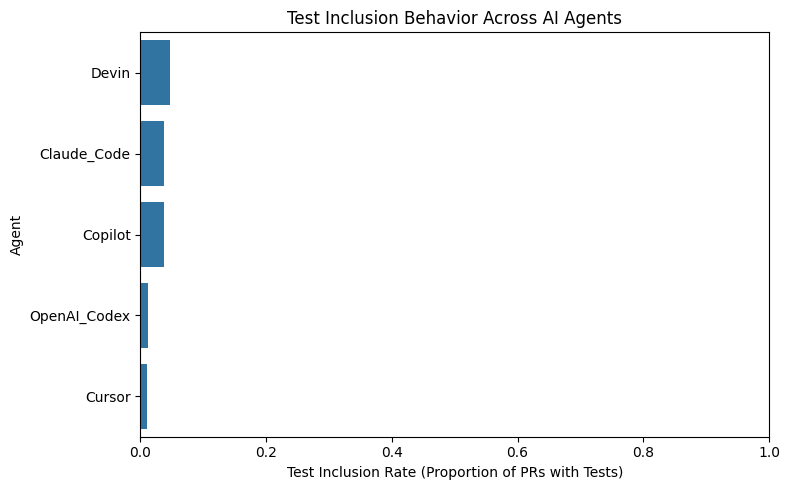

In [9]:
plt.figure(figsize=(8, 5))
sns.barplot(data=agent_inclusion, x="test_inclusion_rate", y="agent")
plt.xlabel("Test Inclusion Rate (Proportion of PRs with Tests)")
plt.ylabel("Agent")
plt.title("Test Inclusion Behavior Across AI Agents")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


## 7. Metric 2: Average Test Files per PR

In [10]:
agent_avg_test = (
    pr_with_type.groupby("agent")["test_file_count"]
    .mean()
    .sort_values(ascending=False)
    .rename("avg_test_file_count")
    .reset_index()
)


In [12]:
import os
FIG_DIR = "../results/figures"
os.makedirs(FIG_DIR, exist_ok=True)

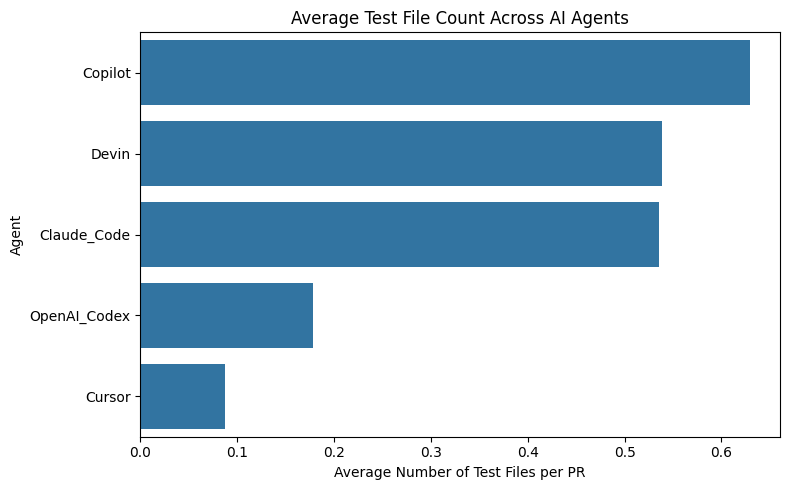

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(8, 5))
sns.barplot(data=agent_avg_test, x="avg_test_file_count", y="agent")
plt.xlabel("Average Number of Test Files per PR")
plt.ylabel("Agent")
plt.title("Average Test File Count Across AI Agents")
plt.tight_layout()
plt.show()
plt.savefig(f"{FIG_DIR}/rq1_average_test_file_counts.png", dpi=300, bbox_inches="tight")

## 8 Metric 3: Conditional Avg (Only PRs with Tests)


In [14]:
has_test = pr_with_type[pr_with_type["test_file_count"] > 0]

agent_conditional = (
    has_test.groupby("agent")["test_file_count"]
    .mean()
    .sort_values(ascending=False)
    .rename("conditional_avg_test_file_count")
    .reset_index()
)


### Plot 3 — Conditional Test Contribution

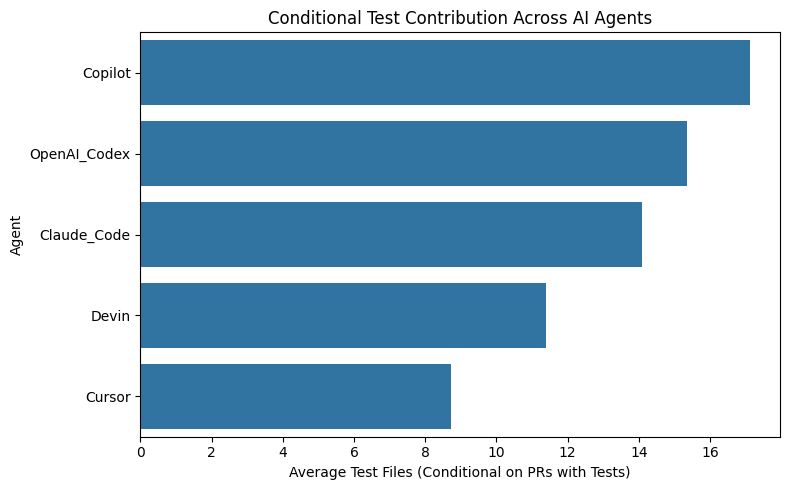

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(8, 5))
sns.barplot(data=agent_conditional, x="conditional_avg_test_file_count", y="agent")
plt.xlabel("Average Test Files (Conditional on PRs with Tests)")
plt.ylabel("Agent")
plt.title("Conditional Test Contribution Across AI Agents")
plt.tight_layout()
plt.show()
plt.savefig(f"{FIG_DIR}/rq1_conditional_test_contribution.png", dpi=300, bbox_inches="tight")

## 9 Summary Heatmap

In [16]:
test_behavior = (
    agent_inclusion.set_index("agent")
    .join(agent_avg_test.set_index("agent"))
    .join(agent_conditional.set_index("agent"))
)


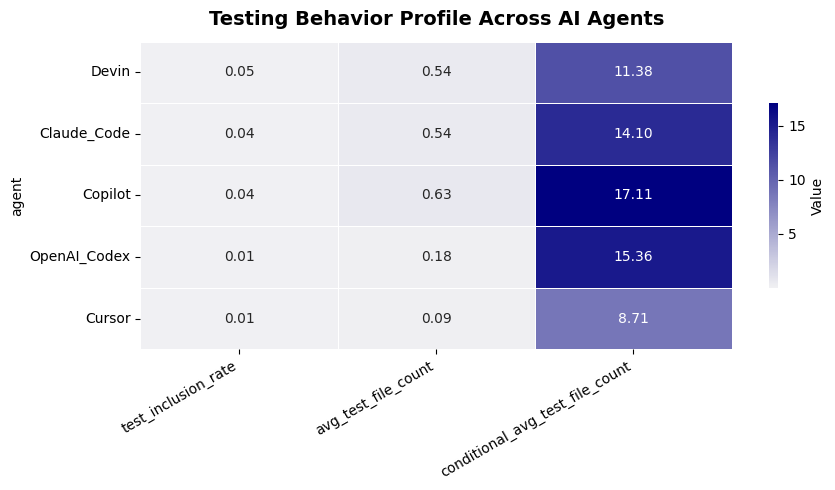

<Figure size 640x480 with 0 Axes>

In [17]:
plt.figure(figsize=(9, 5))
cmap = sns.light_palette("navy", as_cmap=True)
ax = sns.heatmap(
    test_behavior,
    annot=True,
    cmap=cmap,
    fmt=".2f",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.6, "label": "Value"}
)
plt.title("Testing Behavior Profile Across AI Agents", fontsize=14, fontweight="bold", pad=12)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()
plt.savefig(f"{FIG_DIR}/rq1_testing_behavior_profile.png", dpi=300, bbox_inches="tight")

## 9 Agent × Task Type Analysis

In [18]:
type_inclusion = (
    pr_with_type.groupby(["agent", "task_type"])["contains_test"]
    .mean()
    .rename("test_inclusion_rate")
    .reset_index()
)

major_types = (
    type_inclusion["task_type"].value_counts().head(5).index
)

type_inclusion_major = type_inclusion[type_inclusion["task_type"].isin(major_types)]


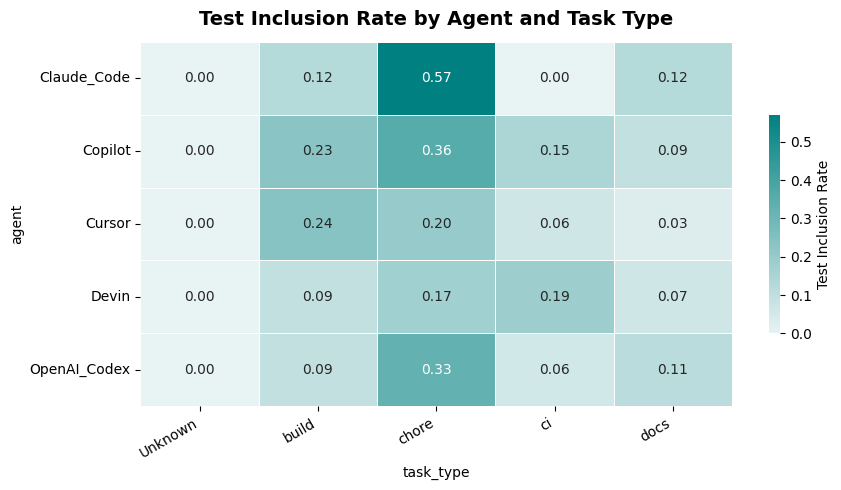

<Figure size 640x480 with 0 Axes>

In [19]:
pivot_type = type_inclusion_major.pivot(
    index="agent",
    columns="task_type",
    values="test_inclusion_rate"
)

plt.figure(figsize=(9, 5))
cmap = sns.light_palette("teal", as_cmap=True)
ax = sns.heatmap(
    pivot_type,
    annot=True,
    cmap=cmap,
    fmt=".2f",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.6, "label": "Test Inclusion Rate"}
)
plt.title("Test Inclusion Rate by Agent and Task Type", fontsize=14, fontweight="bold", pad=12)
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
plt.tight_layout()
plt.show()
plt.savefig(f"{FIG_DIR}/rq1_test_inclusion_rate.png", dpi=300, bbox_inches="tight")

## Analysis:

Our agent–task-type heatmap reveals strong task dependency in AI-generated testing behavior.
All agents exhibit a 0% test inclusion rate for “unknown” PRs, indicating that test generation is not triggered for unclassified or trivial updates.

Across meaningful categories, chore PRs show the highest potential for test generation. Claude_Code performs particularly well with a 57% test inclusion rate, substantially higher than all other agents. Copilot and OpenAI Codex also show moderate testing activity in this category. In contrast, Devin remains consistently low across all types, suggesting limited built-in testing tendencies.

For build, ci, and docs PRs, test inclusion rates remain uniformly low across agents, which is expected given the non-functional nature of these tasks.

Overall, the pattern suggests that AI agents do not follow a general “test-by-default” behavior. Instead, test inclusion happens only in specific PR categories, and even within these categories, substantial variation exists among agents.